In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
#loading data 
item_categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
sales_train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
sample_submission = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')
shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')

In [4]:
# date sütunun datetime formatına çevrilmesi 
sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')

# Yıl, ay ve günü ayrı sütunlar olarak çıkarılır
sales_train['year'] = sales_train['date'].dt.year
sales_train['month'] = sales_train['date'].dt.month
sales_train['day'] = sales_train['date'].dt.day

print(sales_train.head())

        date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-02               0       59    22154      999.00           1.0   
1 2013-01-03               0       25     2552      899.00           1.0   
2 2013-01-05               0       25     2552      899.00          -1.0   
3 2013-01-06               0       25     2554     1709.05           1.0   
4 2013-01-15               0       25     2555     1099.00           1.0   

   year  month  day  
0  2013      1    2  
1  2013      1    3  
2  2013      1    5  
3  2013      1    6  
4  2013      1   15  


In [5]:
# Veri setindeki eksik değerlerin kontrol edilmesi
print(sales_train.isnull().sum())

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
year              0
month             0
day               0
dtype: int64


In [6]:
# bozuk verilerin kontrol edilmesi

# item_price'da sıfır veya negatif değerlerin kontrol edilmesi
print(sales_train[sales_train['item_price'] <= 0])

# item_cnt_day'de negatif değerlerin kontrol edilmesi
print(sales_train[sales_train['item_cnt_day'] < 0])

             date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
484683 2013-05-15               4       32     2973        -1.0           1.0   

        year  month  day  
484683  2013      5   15  
              date  date_block_num  shop_id  item_id  item_price  \
2       2013-01-05               0       25     2552       899.0   
148     2013-01-23               0       25     2321       999.0   
175     2013-01-07               0       25     2199      1449.0   
807     2013-01-02               0       25     2330       599.0   
1041    2013-01-13               0       25     5034      1989.0   
...            ...             ...      ...      ...         ...   
2934243 2015-10-26              33       25     3917       449.0   
2934462 2015-10-18              33       25     4896      6398.0   
2935263 2015-10-05              33       25    10039       249.0   
2935643 2015-10-16              33       25     7893      2990.0   
2935779 2015-10-07              33 

In [7]:
# Geçersiz item_price değerlerini ilgili ürünün medyan fiyatıyla değiştirilmesi
sales_train.loc[sales_train['item_price'] <= 0, 'item_price'] = sales_train.groupby('item_id')['item_price'].transform('median')

# Değişikliklerin doğrulanması
print(sales_train[sales_train['item_price'] <= 0])  # Boş bir DataFrame döndürmelidir

# Negatif item_cnt_day değerlerinin 0 ile değiştirilmesi
sales_train.loc[sales_train['item_cnt_day'] < 0, 'item_cnt_day'] = 0

# Değişikliklerin doğrulanması
print(sales_train[sales_train['item_cnt_day'] < 0])  # Boş bir DataFrame döndürmelidir

Empty DataFrame
Columns: [date, date_block_num, shop_id, item_id, item_price, item_cnt_day, year, month, day]
Index: []
Empty DataFrame
Columns: [date, date_block_num, shop_id, item_id, item_price, item_cnt_day, year, month, day]
Index: []


In [8]:
# günlük verilerin aylık satışlara (date_block_num) göre birleştirilmesi.
# Satışları 'date_block_num', 'shop_id' ve 'item_id' sütunlarına göre birleştirilmesi
monthly_data = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
    'item_cnt_day': 'sum',
    'item_price': 'mean'
}).reset_index()

# Birleştirilen sütunu yeniden adlandır
monthly_data.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)

# Sonuç veri setini kontrol et
print(monthly_data.head())

   date_block_num  shop_id  item_id  item_cnt_month  item_price
0               0        0       32             6.0       221.0
1               0        0       33             3.0       347.0
2               0        0       35             1.0       247.0
3               0        0       43             1.0       221.0
4               0        0       51             2.0       128.5


In [9]:
# önceki aylardan gelen satış bilgilerini dahil etmemizi sağlar; bu, zaman serisi tahmini için kritik öneme sahiptir.
#  mevcut ayın verilerini (örneğin, Mart ayı satışları) alır ve aynı mağaza ve ürün kombinasyonu için önceki aylara ait satışları temsil eden yeni bir sütun ekler.
# item_cnt_month için gecikme özelliği oluştur
for lag in range(1, 4):  # Son 3 aya ait gecikme özellikleri oluşturulur
    monthly_data[f'item_cnt_month_lag_{lag}'] = monthly_data.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(lag)

# Gecikme özelliklerinin doğrulanması
print(monthly_data.head())

   date_block_num  shop_id  item_id  item_cnt_month  item_price  \
0               0        0       32             6.0       221.0   
1               0        0       33             3.0       347.0   
2               0        0       35             1.0       247.0   
3               0        0       43             1.0       221.0   
4               0        0       51             2.0       128.5   

   item_cnt_month_lag_1  item_cnt_month_lag_2  item_cnt_month_lag_3  
0                   NaN                   NaN                   NaN  
1                   NaN                   NaN                   NaN  
2                   NaN                   NaN                   NaN  
3                   NaN                   NaN                   NaN  
4                   NaN                   NaN                   NaN  


In [10]:
# ilk birkaç ay için eksik değerlere sahip olacaktır (çünkü önceki aylar mevcut değildir). Bu değerlerin uygun şekilde doldurulması.
# Eksik gecikme değerlerini sıfırlarla doldur
monthly_data.fillna(0, inplace=True)

# Gecikme özelliklerinin doğrulanması
print(monthly_data.head())

   date_block_num  shop_id  item_id  item_cnt_month  item_price  \
0               0        0       32             6.0       221.0   
1               0        0       33             3.0       347.0   
2               0        0       35             1.0       247.0   
3               0        0       43             1.0       221.0   
4               0        0       51             2.0       128.5   

   item_cnt_month_lag_1  item_cnt_month_lag_2  item_cnt_month_lag_3  
0                   0.0                   0.0                   0.0  
1                   0.0                   0.0                   0.0  
2                   0.0                   0.0                   0.0  
3                   0.0                   0.0                   0.0  
4                   0.0                   0.0                   0.0  


In [11]:
# Özellikler (X) ve hedef değişkeni (y) tanımlanması ; Özellikler (X), hedefi tahmin etmeye yardımcı olan tüm sütunlardır
X = monthly_data.drop(['item_cnt_month'], axis=1)  # Hedef sütunun özelliklerden çıkarılması
y = monthly_data['item_cnt_month']  # Hedef sütunu ==>> tahmin etmek istediğimiz

In [12]:
# Veriyi ayır ===>>> %20 test olarak ayrıldı
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Her setin boyutunu kontrol edin
print("Eğitim seti boyutu:", X_train.shape)
print("Test seti boyutu:", X_test.shape)

Eğitim seti boyutu: (1287299, 7)
Test seti boyutu: (321825, 7)


In [13]:
# Özellikleri Standartlaştırma veya Normalize Etme ; tüm özelliklerin aynı ölçek aralığında olmasını sağlar
# Standartlaştırıcıyı başlat
scaler = StandardScaler()

# Eğitim verilerinin fit ve transform edilmesi
# fit(): Eğitim verilerinin ortalamasını ve standart sapmasını öğrenir.
# transform(): Eğitim verilerini öğrendiği bu değerler kullanılarak dönüştürür (standartlaştırır).
X_train = scaler.fit_transform(X_train)

# Sadece test verileri transform edilir (fit edilmez)
# fit() kullanılmaz çünkü test verileri modelin "görmediği" veriler olarak kalmalıdır.
X_test = scaler.transform(X_test)

In [14]:
# Random Forest modelinin başlatılması
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [15]:
# Modelin eğitilmesi
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [16]:
# Test setinde tahmin yapılması
y_pred = model.predict(X_test)

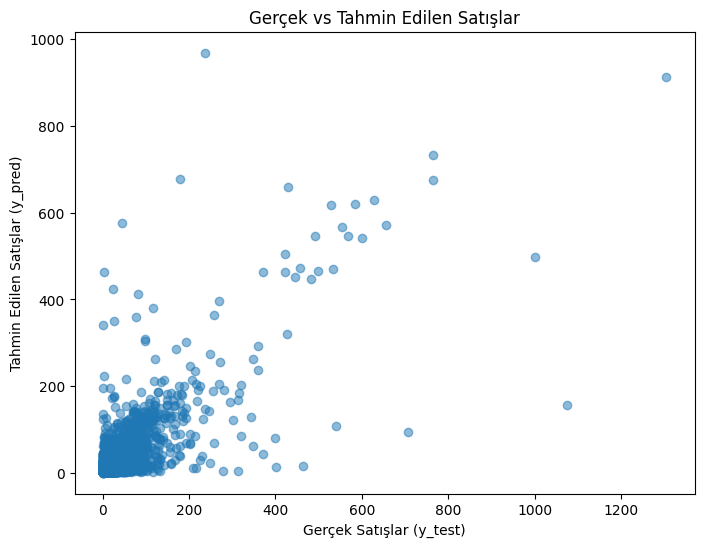

In [18]:
#  Gerçek Satışlar (y_test) ve Tahmin Edilen Satışlar (y_pred) arasındaki ilişkileri görselleştiren bir dağılım grafiği (scatter plot) oluşturur.
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Gerçek Satışlar (y_test)")
plt.ylabel("Tahmin Edilen Satışlar (y_pred)")
plt.title("Gerçek vs Tahmin Edilen Satışlar")
plt.show()

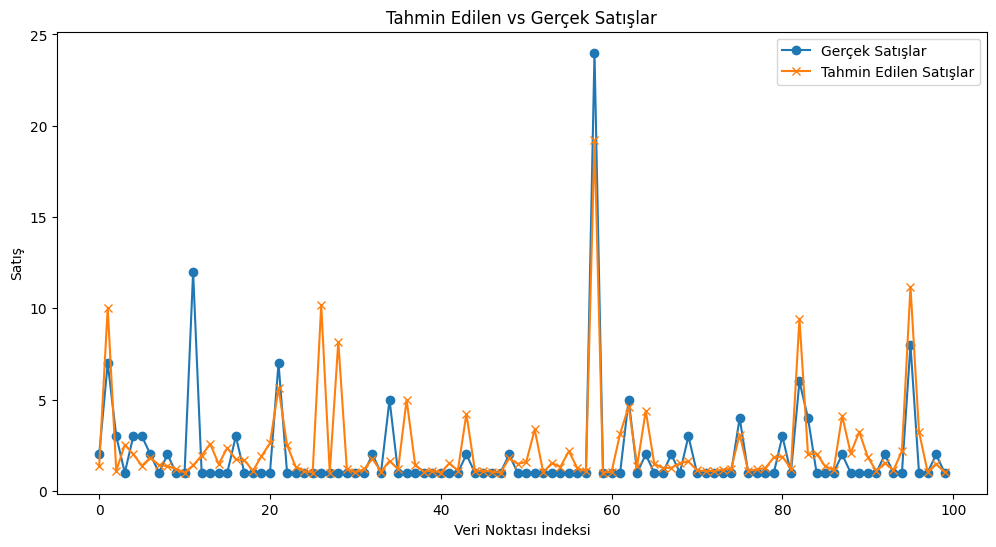

In [20]:
# Test veri setinin belirli bir alt kümesi için modelin tahmin ettiği satış değerlerini (y_pred) ve gerçek satış değerlerini (y_test) görselleştiren bir çizgi grafiği oluşturur. 
subset = 100  # İlk 100 veri noktasını görselleştirir.
plt.figure(figsize=(12, 6))
plt.plot(range(subset), y_test[:subset], label="Gerçek Satışlar", marker='o')
plt.plot(range(subset), y_pred[:subset], label="Tahmin Edilen Satışlar", marker='x')
plt.xlabel("Veri Noktası İndeksi")
plt.ylabel("Satış")
plt.title("Tahmin Edilen vs Gerçek Satışlar")
plt.legend()
plt.show()

In [17]:
# Modelin değerlendirilmesi
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Ortalama Mutlak Hata (MAE):", mae)
print("Ortalama Kare Hata (MSE):", mse)
print("R² Skoru:", r2)

Ortalama Mutlak Hata (MAE): 1.1100444030140606
Ortalama Kare Hata (MSE): 26.931407075273817
R² Skoru: 0.590622881430531
